## MSM.jl and ApproxBayes.jl

This notebook shows how one can estimate a model using [MSM.jl](https://github.com/JulienPascal/MSM.jl) and [ApproxBayes.jl](https://github.com/marcjwilliams1/ApproxBayes.jl)

In [1]:
using MSM
using ApproxBayes
using DataStructures
using OrderedCollections
using Distributions
using Random
using DataStructures
using Statistics
using LinearAlgebra

In [2]:
Random.seed!(1234)  #for replicability reasons
T = 100000          #number of periods
P = 2               #number of dependent variables
beta0 = rand(P)     #choose true coefficients by drawing from a uniform distribution on [0,1]
alpha0 = rand(1)[]  #intercept
theta0 = 0.0        #coefficient to create serial correlation in the error terms
println("True intercept = $(alpha0)")
println("True coefficient beta0 = $(beta0)")
println("Serial correlation coefficient theta0 = $(theta0)")

# Generation of error terms
# row = individual dimension
# column = time dimension 
U = zeros(T)
d = Normal()
U[1] = rand(d, 1)[] #first error term
# loop over time periods
for t = 2:T
    U[t] = rand(d, 1)[] + theta0*U[t-1]
end

# Let's simulate the dependent variables x_t
x = zeros(T, P)

d = Uniform(0, 5)
for p = 1:P  
    x[:,p] = rand(d, T)
end

# Let's calculate the resulting y_t
y = zeros(T)

for t=1:T
    y[t] = alpha0 + x[t,1]*beta0[1] + x[t,2]*beta0[2] + U[t]
end

optionsSMM = MSMOptions(maxFuncEvals=1000, globalOptimizer = :dxnes, localOptimizer = :NelderMead)
myProblem = MSMProblem(options = optionsSMM);

# Priors
dictPriors = OrderedDict{String,Array{Float64,1}}()
dictPriors["alpha"] = [0.5, 0.001, 1.0]
dictPriors["beta1"] = [0.5, 0.001, 1.0]
dictPriors["beta2"] = [0.5, 0.001, 1.0]
set_priors!(myProblem, dictPriors)

# Empirical moments
dictEmpiricalMoments = OrderedDict{String,Array{Float64,1}}()
dictEmpiricalMoments = OrderedDict{String,Array{Float64,1}}()
dictEmpiricalMoments["mean"] = [mean(y)] #informative on the intercept
dictEmpiricalMoments["mean^2"] = [mean(y.^2)] #informative on the intercept
dictEmpiricalMoments["mean^3"] = [mean(y.^3)] #informative on the intercept
dictEmpiricalMoments["mean_x1y"] = [mean(x[:,1] .* y)] #informative on betas
dictEmpiricalMoments["mean_x2y"] = [mean(x[:,2] .* y)] #informative on betas
dictEmpiricalMoments["mean_x1y^2"] = [mean((x[:,1] .* y).^2)] #informative on betas
dictEmpiricalMoments["mean_x2y^2"] = [mean((x[:,2] .* y).^2)] #informative on betas
set_empirical_moments!(myProblem, dictEmpiricalMoments)

W = Matrix(1.0 .* I(length(dictEmpiricalMoments)))#initialization
#Special case: diagonal matrix
#(you may choose something else)
for (indexMoment, k) in enumerate(keys(myProblem.empiricalMoments))
    W[indexMoment,indexMoment] = 1.0/(myProblem.empiricalMoments[k][1])^2
end
set_weight_matrix!(myProblem, W)


# x[1] corresponds to the intercept, x[2] corresponds to beta1, x[3] corresponds to beta2
function functionLinearModel(x; uniform_draws::Array{Float64,1}, simX::Array{Float64,2}, nbDraws::Int64 = length(uniform_draws), burnInPerc::Int64 = 10)
    T = nbDraws
    P = 2       #number of dependent variables

    alpha = x[1]
    beta = x[2:end]
    theta = 0.0     #coefficient to create serial correlation in the error terms

    # Creation of error terms
    # row = individual dimension
    # column = time dimension
    U = zeros(T)
    d = Normal()
    # Inverse cdf (i.e. quantile)
    gaussian_draws = quantile.(d, uniform_draws)
    U[1] = gaussian_draws[1] #first error term

    # loop over time periods
    for t = 2:T
        U[t] = gaussian_draws[t] + theta*U[t-1]
    end

    # Let's calculate the resulting y_t
    y = zeros(T)

    for t=1:T
        y[t] = alpha + simX[t,1]*beta[1] + simX[t,2]*beta[2] + U[t]
    end

    # Get rid of the burn-in phase:
    #------------------------------
    startT = div(nbDraws, burnInPerc)

    # Moments:
    #---------
    output = OrderedDict{String,Float64}()
    output["mean"] = mean(y[startT:nbDraws])
    output["mean^2"] = mean(y[startT:nbDraws].^2)
    output["mean^3"] = mean(y[startT:nbDraws].^3)
    output["mean_x1y"] = mean(simX[startT:nbDraws,1] .* y[startT:nbDraws])
    output["mean_x2y"] = mean(simX[startT:nbDraws,2] .* y[startT:nbDraws])
    output["mean_x1y^2"] = mean((simX[startT:nbDraws,1] .* y[startT:nbDraws]).^2)
    output["mean_x2y^2"] = mean((simX[startT:nbDraws,2] .* y[startT:nbDraws]).^2)

    return output
end

# Let's freeze the randomness during the minimization
d_Uni = Uniform(0,1)
nbDraws = 100000 #number of draws in the simulated data
uniform_draws = rand(d_Uni, nbDraws)
simX = zeros(length(uniform_draws), 2)
d = Uniform(0, 5)
for p = 1:2
  simX[:,p] = rand(d, length(uniform_draws))
end

set_simulate_empirical_moments!(myProblem, x -> functionLinearModel(x, uniform_draws = uniform_draws, simX = simX))
construct_objective_function!(myProblem)

True intercept = 0.5662374165061859
True coefficient beta0 = [0.5908446386657102, 0.7667970365022592]
Serial correlation coefficient theta0 = 0.0


(::MSM.var"#objective_function_MSM#6"{MSMProblem}) (generic function with 1 method)

In [3]:
n_threads = Threads.nthreads()
println("Number of threads = $(n_threads)")

Number of threads = 1


In [4]:
targetdata = collect(values(dictEmpiricalMoments))

7-element Vector{Vector{Float64}}:
 [3.952878050375794]
 [18.567217663660667]
 [96.65242233117469]
 [11.061079621971047]
 [11.463383169522919]
 [203.36060647937504]
 [219.24881943710466]

In [6]:
initial_guess = myProblem.objective_function([dictPriors[k][1] for k in keys(dictPriors)])
ϵ = initial_guess/100

0.009583530743202397

In [7]:
#Use dictPriors to create a prior for ApproxBayes
priors = ""
for (i, k) in enumerate(keys(myProblem.priors))
  if i==1
  priors = string("Uniform($(dictPriors[k][2]), $(dictPriors[k][3]))" )
  else
      priors = string(priors, ", ", "Uniform($(dictPriors[k][2]), $(dictPriors[k][3]))" )
  end
end

priors = eval(Meta.parse(string("Prior([", priors, "])")))

Prior((Uniform{Float64}(a=0.001, b=1.0), Uniform{Float64}(a=0.001, b=1.0), Uniform{Float64}(a=0.001, b=1.0)))

In [8]:
setup = ABCRejection((params, constants, targetdata) -> (myProblem.objective_function(params), 1), #simulation function
  length(dictPriors), # number of parameters
  ϵ, #target ϵ. 
  priors; # Prior for each of the parameters
  maxiterations = 10^6, #Maximum number of iterations before the algorithm terminates
  )

# run ABC inference
@time res = runabc(setup, targetdata, verbose=true, progress=true, parallel=true)

Preparing to run in parallel on 1 processors
 42.023340 seconds (7.56 M allocations: 104.202 GiB, 10.94% gc time, 6.34% compilation time)
Number of simulations: 7.61e+03
Acceptance ratio: 1.31e-02

Median (95% intervals):
Parameter 1: 0.49 (0.07,0.96)


Parameter 2: 0.59 (0.44,0.75)
Parameter 3: 0.77 (0.62,0.92)


In [9]:
println("True intercept = $(alpha0)")
println("True coefficient beta0 = $(beta0)")

True intercept = 0.5662374165061859
True coefficient beta0 = [0.5908446386657102, 0.7667970365022592]


┌ Warning: Attribute alias `nbins` detected in the user recipe defined for the signature (::ApproxBayes.ABCrejectionresults). To ensure expected behavior it is recommended to use the default attribute `bins`.
└ @ Plots /home/julien/.julia/packages/Plots/g581z/src/pipeline.jl:26


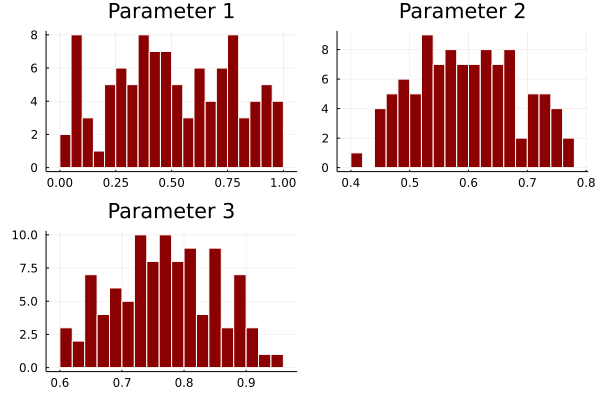

In [10]:
using Plots
plot(res)

In [11]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
